## Importing all the necessary libraries

In [ ]:
!pip install category_encoders
!pip install dabl

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import category_encoders as ce
import dabl
import time
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize, LabelEncoder, OneHotEncoder

import plotly.graph_objects as go
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Metrics dictionary
accuracy = dict()
precision = dict()
recall = dict()
f1 = dict()
fpr = dict()
tpr = dict()

## Reading the data

In [ ]:
df = pd.read_csv('US_Accidents_March23_sampled_500k.csv', nrows=4000)
display(df)
column = df.columns
# all the categorical columns
cat_columns = [colname for colname in df.select_dtypes(["object", "category"])]
len(cat_columns)

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,False,False,False,False,False,False,Night,Night,Night,Night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,A-3039826,Source2,3,2018-01-01 16:37:09,2018-01-01 17:21:49,34.034649,-118.267052,NaN,NaN,0.000,...,False,False,False,False,False,False,Day,Day,Day,Day
3996,A-7473792,Source1,2,2018-12-02 11:12:04,2018-12-02 11:41:20,32.793539,-97.212420,32.775740,-97.212810,1.230,...,False,False,False,False,False,False,Day,Day,Day,Day
3997,A-7207927,Source1,2,2020-03-01 17:50:00,2020-03-01 18:23:34,34.143044,-117.318265,34.143044,-117.318265,0.000,...,False,False,False,False,False,False,Night,Day,Day,Day
3998,A-6018197,Source1,2,2021-08-19 17:13:00,2021-08-19 22:02:13,34.602169,-117.635630,34.602170,-117.634631,0.057,...,False,False,False,False,False,False,Day,Day,Day,Day


20

In [ ]:
X.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Weather_Condition_Windy,Civil_Twilight_Day,Civil_Twilight_Night,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
0,1,0.646508,0.348937,0.000000,0.449064,0.166667,0.191877,0.662162,0.226415,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0.993655,0.014886,0.257687,0.667360,0.468750,0.928571,0.662162,0.113208,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,0.750957,0.989122,0.000000,0.407484,0.406250,0.745098,0.662162,0.490566,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,0.579510,0.006255,0.000000,0.854470,0.145833,0.896359,0.662162,0.301887,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,0.411929,0.767306,0.000000,0.823285,0.583333,0.743697,0.662162,0.490566,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# describe categorical columns
df.describe(include='object')

,ID,Source,Start_Time,End_Time,Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Wind_Direction,Weather_Condition,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
count,4000,4000,4000,4000,4000,3992,4000,4000,4000,4000,4000,3995,3985,3939,3914,3912,3994,3994,3994,3994
unique,4000,3,3999,4000,3970,2740,1467,545,47,3182,1,4,764,3896,24,48,2,2,2,2
top,A-2047758,Source1,2020-10-22 23:54:00,2019-06-12 10:55:58,A crash has occurred causing no to minimum del...,I-95 N,Miami,Los Angeles,CA,37210,US,US/Eastern,KCQT,2021-12-11 13:53:00,CALM,Fair,Day,Day,Day,Day
freq,1,2201,2,1,8,44,98,267,896,9,4000,1835,63,2,496,1293,2798,2998,3170,3298


In [ ]:
df.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

## Exploratory Data Analysis

In [ ]:
state_counts = df["State"].value_counts()
fig = go.Figure(data=go.Choropleth(locations=state_counts.index, z=state_counts.values.astype(float), locationmode="USA-states", colorscale="turbo"))
fig.update_layout(title_text="Number of US Accidents for each State", geo_scope="usa")
fig.show()

<ipython-input-201-da259d883998>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




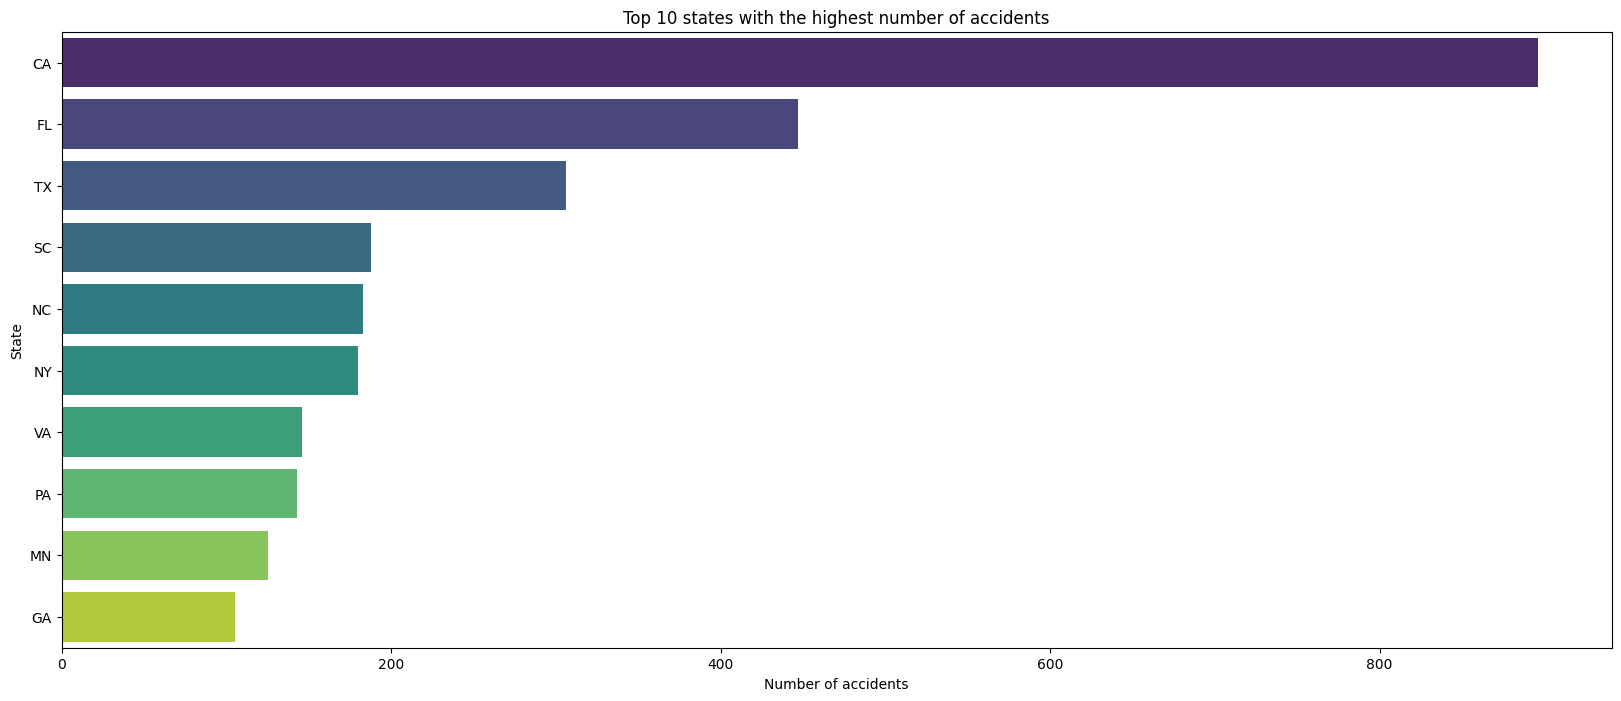

In [ ]:
plt.figure(figsize=(20, 8))
plt.title("Top 10 states with the highest number of accidents")
sns.barplot(x=state_counts[:10].values, y=state_counts[:10].index, orient="h", palette="viridis")
plt.xlabel("Number of accidents")
plt.ylabel("State")
plt.show()

<ipython-input-202-7d7fa243e6ac>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




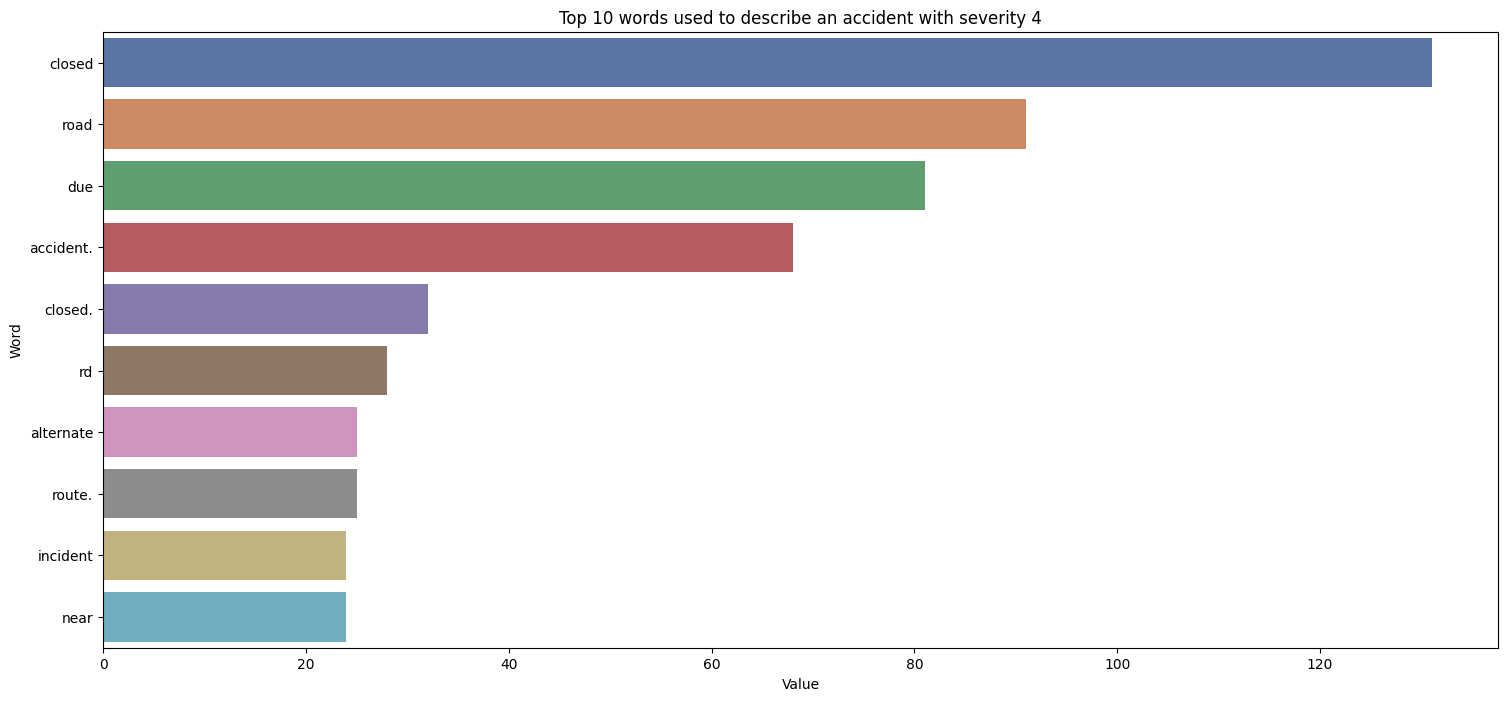

In [ ]:
stop = stopwords.words("english") + ["-"]

df_s4_desc = df[df["Severity"] == 4]["Description"]
# Split the description
df_words = df_s4_desc.str.lower().str.split(expand=True).stack()

# If the word is not in the stopwords list
counts = df_words[~df_words.isin(stop)].value_counts()[:10]

plt.figure(figsize=(18, 8))
plt.title("Top 10 words used to describe an accident with severity 4")
sns.barplot(x=counts.values, y=counts.index, palette="deep")
plt.xlabel("Value")
plt.ylabel("Word")
plt.show()

<ipython-input-203-7186130da21b>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




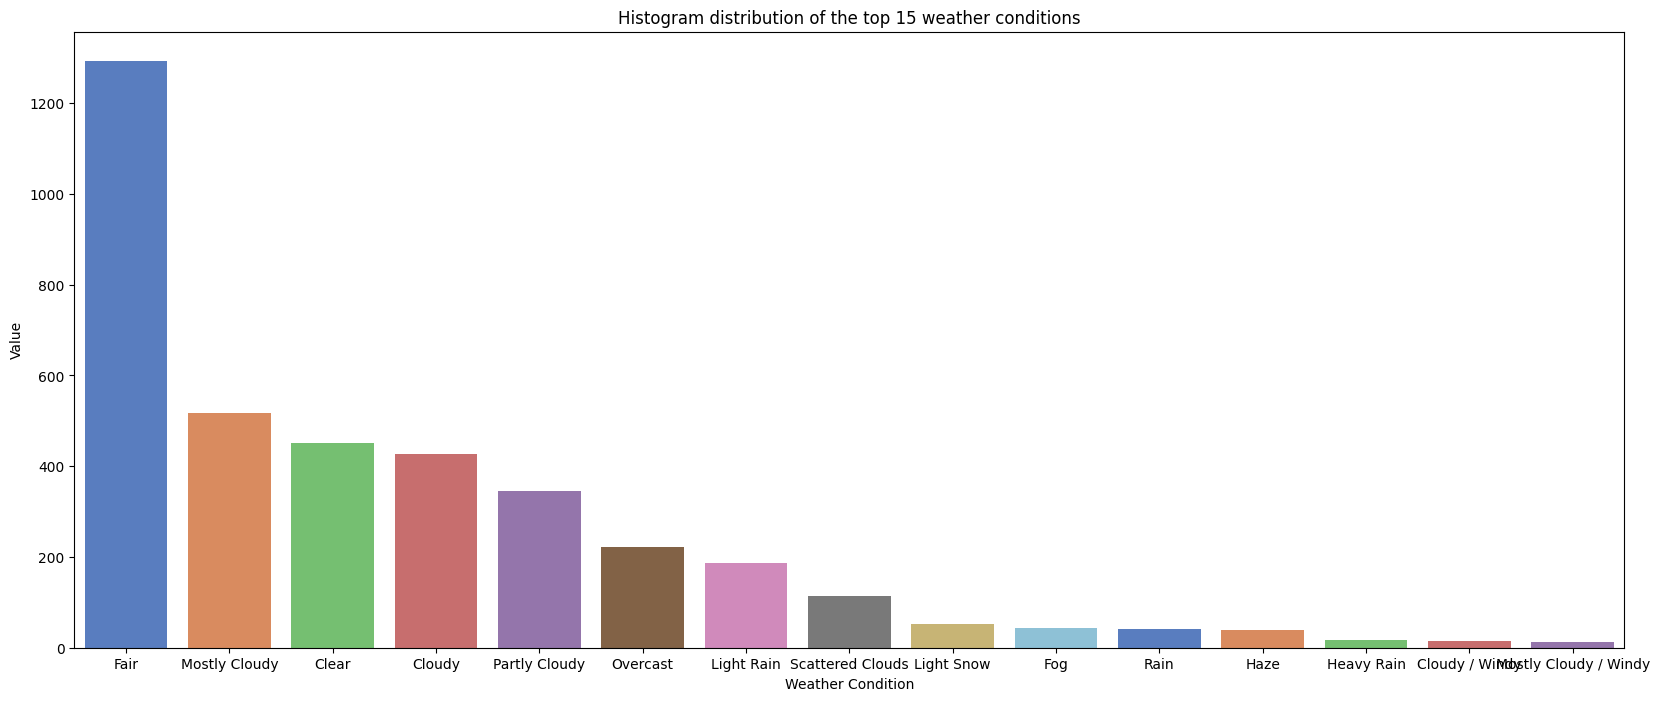

In [ ]:
counts = df["Weather_Condition"].value_counts()[:15]
plt.figure(figsize=(20, 8))
plt.title("Histogram distribution of the top 15 weather conditions")
sns.barplot(x=counts.index, y=counts.values, palette="muted")
plt.xlabel("Weather Condition")
plt.ylabel("Value")
plt.show()

<ipython-input-204-12d0e8a71489>:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




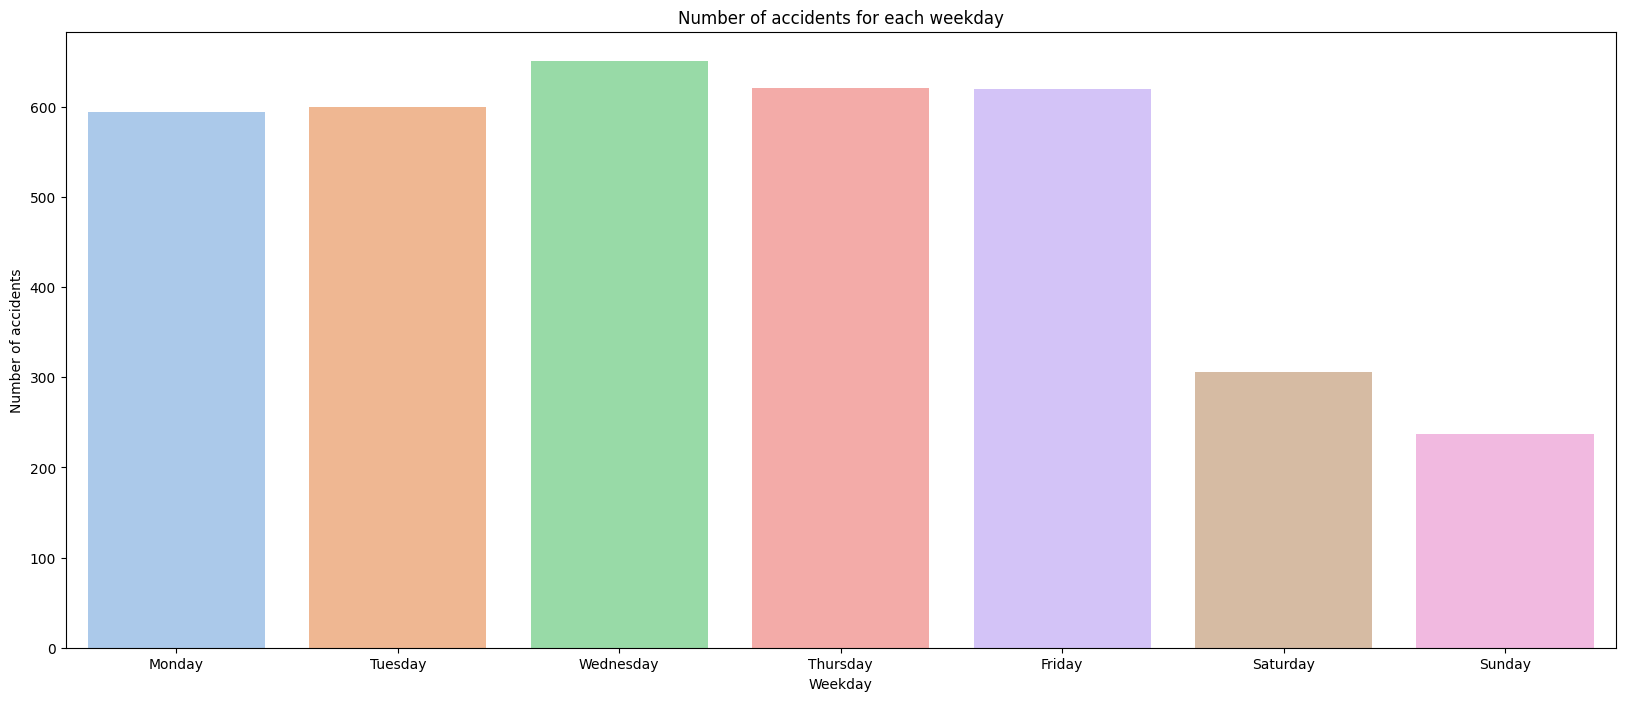

In [ ]:
# Define the list of weekdays
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Convert 'Start_Time' column to datetime with format and handle errors
counts = pd.to_datetime(df['Start_Time'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.day_name().value_counts()

# Reindex the counts to ensure all weekdays are present
counts = counts.reindex(weekdays)

# Plot the counts
plt.figure(figsize=(20, 8))
plt.title("Number of accidents for each weekday")
sns.barplot(x=counts.index, y=counts.values, order=weekdays, palette="pastel")
plt.xlabel("Weekday")
plt.ylabel("Number of accidents")
plt.show()

In [ ]:
import dabl
dabl.detect_types(df)

/usr/local/lib/python3.10/dist-packages/dabl/preprocessing.py:172: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/usr/local/lib/python3.10/dist-packages/dabl/preprocessing.py:172: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/usr/local/lib/python3.10/dist-packages/dabl/preprocessing.py:172: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/usr/local/lib/python3.10/dist-packages/dabl/preprocessing.py:172: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify

,continuous,dirty_float,low_card_int_ordinal,low_card_int_categorical,categorical,date,free_string,useless
ID,False,False,False,False,False,False,True,False
Source,False,False,False,False,True,False,False,False
Severity,False,False,False,False,True,False,False,False
Start_Time,False,False,False,False,False,False,True,False
End_Time,False,False,False,False,False,False,True,False
Start_Lat,True,False,False,False,False,False,False,False
Start_Lng,True,False,False,False,False,False,False,False
End_Lat,True,False,False,False,False,False,False,False
End_Lng,True,False,False,False,False,False,False,False
Distance(mi),True,False,False,False,False,False,False,False


## Data Preprocessing

In [ ]:
X = df
X.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,False,False,False,False,False,False,Night,Night,Night,Night


In [ ]:
# Cast Start_Time to datetime with format and handle errors
X["Start_Time"] = pd.to_datetime(X["Start_Time"], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Extract year, month, weekday, and day
X["Year"] = X["Start_Time"].dt.year
X["Month"] = X["Start_Time"].dt.month
X["Weekday"] = X["Start_Time"].dt.day_name()
X["Day"] = X["Start_Time"].dt.day

X.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Weekday,Day
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,True,False,Day,Day,Day,Day,2019.0,6.0,Wednesday,12.0
1,A-4694324,Source1,2,NaT,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,False,False,Night,Night,Night,Night,NaN,NaN,NaN,NaN
2,A-5006183,Source1,2,NaT,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,...,True,False,Day,Day,Day,Day,NaN,NaN,NaN,NaN
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,False,False,Day,Day,Day,Day,2022.0,2.0,Monday,21.0
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,False,False,Night,Night,Night,Night,2020.0,12.0,Friday,4.0


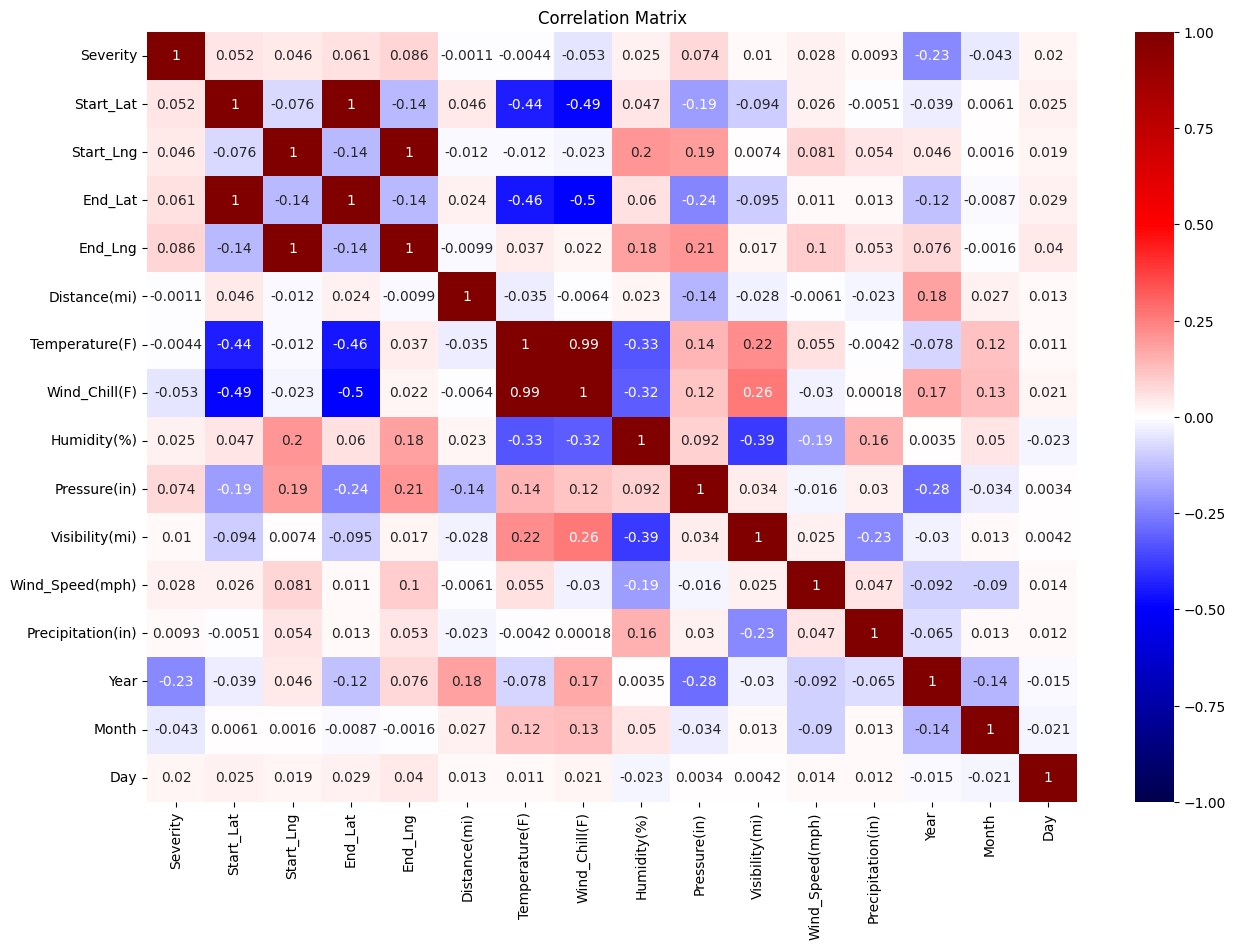

In [ ]:
# Select only numeric columns
numeric_columns = X.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_columns.corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap="seismic", xticklabels=True, yticklabels=True, annot=True,
            cbar_kws={"orientation": "vertical"})
plt.gca().patch.set(hatch="X", edgecolor="#666")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
features_to_drop = ["ID", "Source", "Start_Time", "End_Time", "End_Lat", "End_Lng", "Description", "Street", "County", "State", "Zipcode", "Country", "Timezone", "Airport_Code", "Weather_Timestamp", "Wind_Chill(F)", "Turning_Loop", "Sunrise_Sunset", "Nautical_Twilight", "Astronomical_Twilight"]
X = X.drop(features_to_drop, axis=1)
X.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),City,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Civil_Twilight,Year,Month,Weekday,Day
0,2,30.641211,-91.153481,0.000,Zachary,77.0,62.0,29.92,10.0,NW,...,False,False,False,False,True,Day,2019.0,6.0,Wednesday,12.0
1,2,38.990562,-77.399070,0.056,Sterling,45.0,48.0,29.91,10.0,W,...,False,False,False,False,False,Night,NaN,NaN,NaN,NaN
2,2,34.661189,-120.492822,0.022,Lompoc,68.0,73.0,29.79,10.0,W,...,False,False,False,False,True,Day,NaN,NaN,NaN,NaN
3,2,43.680592,-92.993317,1.054,Austin,27.0,86.0,28.49,10.0,ENE,...,False,False,False,False,False,Day,2022.0,2.0,Monday,21.0
4,2,35.395484,-118.985176,0.046,Bakersfield,42.0,34.0,29.77,10.0,CALM,...,False,False,False,False,False,Night,2020.0,12.0,Friday,4.0


In [ ]:
print("Number of rows:", len(X.index))
X.drop_duplicates(inplace=True)
print("Number of rows after drop of duplicates:", len(X.index))

Number of rows: 4000
Number of rows after drop of duplicates: 4000


In [ ]:
# Assuming df is your DataFrame
df['Side'] = 'Unknown'  # Add 'Unknown' as default value for all rows
# Assuming df is your DataFrame and you want to copy values from the 'Direction' column
df['Side'] = df['Pressure(in)']

In [ ]:
# Print the column names of the DataFrame
print(df.columns)

# Check if the 'Side' column exists in the DataFrame
if 'Side' in df.columns:
    # Perform operations involving the 'Side' column
    # For example:
    # side_counts = df['Side'].value_counts()
    pass
else:
    print("'Side' column does not exist in the DataFrame")
#df["Side"].value_counts()

Index(['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'City',
       'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Civil_Twilight', 'Year', 'Month',
       'Weekday', 'Day'],
      dtype='object')
'Side' column does not exist in the DataFrame


In [ ]:
"""
X = X[X["Side "] != " "]
X["Side "].value_counts()
"""

'\nX = X[X["Side "] != " "]\nX["Side "].value_counts()\n'

In [ ]:
X[["Pressure(in)", "Visibility(mi)"]].describe().round(2)

,Pressure(in),Visibility(mi)
count,3931.00,3913.00
mean,29.54,9.13
std,0.97,2.72
min,20.37,0.00
25%,29.36,10.00
50%,29.85,10.00
75%,30.03,10.00
max,30.71,70.00


In [ ]:
X = X[X["Pressure(in)"] != 0]
X = X[X["Visibility(mi)"] != 0]
X[["Pressure(in)", "Visibility(mi)"]].describe().round(2)

,Pressure(in),Visibility(mi)
count,3925.00,3907.00
mean,29.54,9.14
std,0.97,2.70
min,20.37,0.06
25%,29.36,10.00
50%,29.86,10.00
75%,30.03,10.00
max,30.71,70.00


In [ ]:
unique_weather = X["Weather_Condition"].unique()

print(len(unique_weather))
print(unique_weather)

49
['Fair' 'Wintry Mix' 'Light Rain' 'Cloudy' 'Mostly Cloudy' 'Partly Cloudy'
 'Clear' 'Scattered Clouds' 'Fog' 'Overcast' 'Light Snow' 'T-Storm' nan
 'Thunderstorms and Rain' 'Thunder' 'Light Rain with Thunder' 'Rain'
 'Showers in the Vicinity' 'Mostly Cloudy / Windy' 'Heavy Rain'
 'Cloudy / Windy' 'Light Drizzle' 'Heavy T-Storm' 'Light Rain / Windy'
 'Smoke' 'Haze' 'Blowing Dust / Windy' 'N/A Precipitation'
 'Thunder in the Vicinity' 'Snow' 'Heavy Thunderstorms and Rain'
 'Shallow Fog' 'Light Freezing Drizzle' 'Fair / Windy' 'Patches of Fog'
 'Light Snow / Windy' 'Blowing Snow / Windy' 'Thunderstorm' 'Drizzle'
 'T-Storm / Windy' 'Partly Cloudy / Windy' 'Heavy Rain / Windy'
 'Heavy Snow / Windy' 'Mist' 'Light Thunderstorms and Rain' 'Rain / Windy'
 'Light Freezing Rain' 'Heavy Snow' 'Light Ice Pellets']


In [ ]:
X.loc[X["Weather_Condition"].str.contains("Thunder|T-Storm", na=False), "Weather_Condition"] = "Thunderstorm"
X.loc[X["Weather_Condition"].str.contains("Snow|Sleet|Wintry", na=False), "Weather_Condition"] = "Snow"
X.loc[X["Weather_Condition"].str.contains("Rain|Drizzle|Shower", na=False), "Weather_Condition"] = "Rain"
X.loc[X["Weather_Condition"].str.contains("Wind|Squalls", na=False), "Weather_Condition"] = "Windy"
X.loc[X["Weather_Condition"].str.contains("Hail|Pellets", na=False), "Weather_Condition"] = "Hail"
X.loc[X["Weather_Condition"].str.contains("Fair", na=False), "Weather_Condition"] = "Clear"
X.loc[X["Weather_Condition"].str.contains("Cloud|Overcast", na=False), "Weather_Condition"] = "Cloudy"
X.loc[X["Weather_Condition"].str.contains("Mist|Haze|Fog", na=False), "Weather_Condition"] = "Fog"
X.loc[X["Weather_Condition"].str.contains("Sand|Dust", na=False), "Weather_Condition"] = "Sand"
X.loc[X["Weather_Condition"].str.contains("Smoke|Volcanic Ash", na=False), "Weather_Condition"] = "Smoke"
X.loc[X["Weather_Condition"].str.contains("N/A Precipitation", na=False), "Weather_Condition"] = np.nan

print(X["Weather_Condition"].unique())

['Clear' 'Snow' 'Rain' 'Cloudy' 'Fog' 'Thunderstorm' nan 'Windy' 'Smoke'
 'Hail']


In [ ]:
X["Wind_Direction"].unique()

array(['NW', 'W', 'ENE', 'CALM', 'SW', 'VAR', 'S', 'E', 'WSW', 'NNE',
       'Variable', 'West', 'N', 'ESE', 'NNW', 'North', 'SSW', 'WNW', 'NE',
       'Calm', 'SE', 'East', 'SSE', 'South', nan], dtype=object)

In [ ]:
X.loc[X["Wind_Direction"] == "CALM", "Wind_Direction"] = "Calm"
X.loc[X["Wind_Direction"] == "VAR", "Wind_Direction"] = "Variable"
X.loc[X["Wind_Direction"] == "East", "Wind_Direction"] = "E"
X.loc[X["Wind_Direction"] == "North", "Wind_Direction"] = "N"
X.loc[X["Wind_Direction"] == "South", "Wind_Direction"] = "S"
X.loc[X["Wind_Direction"] == "West", "Wind_Direction"] = "W"

X["Wind_Direction"] = X["Wind_Direction"].map(lambda x : x if len(x) != 3 else x[1:], na_action="ignore")

X["Wind_Direction"].unique()

array(['NW', 'W', 'NE', 'Calm', 'SW', 'Variable', 'S', 'E', 'N', 'SE',
       nan], dtype=object)

In [ ]:
X.isna().sum()

Severity                0
Start_Lat               0
Start_Lng               0
Distance(mi)            0
City                    0
Temperature(F)         85
Humidity(%)            89
Pressure(in)           69
Visibility(mi)         87
Wind_Direction         86
Wind_Speed(mph)       293
Precipitation(in)    1200
Weather_Condition      94
Amenity                 0
Bump                    0
Crossing                0
Give_Way                0
Junction                0
No_Exit                 0
Railway                 0
Roundabout              0
Station                 0
Stop                    0
Traffic_Calming         0
Traffic_Signal          0
Civil_Twilight          6
Year                  369
Month                 369
Weekday               369
Day                   369
dtype: int64

In [ ]:
features_to_fill = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]
X[features_to_fill] = X[features_to_fill].fillna(X[features_to_fill].mean())

X.dropna(inplace=True)

X.isna().sum()

Severity             0
Start_Lat            0
Start_Lng            0
Distance(mi)         0
City                 0
Temperature(F)       0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Direction       0
Wind_Speed(mph)      0
Precipitation(in)    0
Weather_Condition    0
Amenity              0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
Civil_Twilight       0
Year                 0
Month                0
Weekday              0
Day                  0
dtype: int64

In [ ]:
X.describe().round(2)

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Year,Month,Day
count,3524.00,3524.00,3524.00,3524.00,3524.00,3524.00,3524.00,3524.00,3524.00,3524.00,3524.00,3524.00,3524.00
mean,2.24,36.24,-94.92,0.44,62.18,65.01,29.57,9.16,7.76,0.01,2019.60,6.79,15.59
std,0.51,5.15,17.37,1.14,18.47,22.98,0.94,2.72,5.17,0.04,1.91,3.59,8.71
min,1.00,24.88,-124.35,0.00,-35.00,4.00,20.37,0.06,0.00,0.00,2016.00,1.00,1.00
25%,2.00,33.41,-117.24,0.00,50.00,48.00,29.39,10.00,4.60,0.00,2018.00,4.00,8.00
50%,2.00,35.75,-87.97,0.01,64.00,67.00,29.87,10.00,7.00,0.00,2020.00,7.00,15.00
75%,2.00,40.14,-80.46,0.35,75.90,84.00,30.04,10.00,10.00,0.01,2021.00,10.00,23.00
max,4.00,48.90,-70.21,18.97,115.00,100.00,30.71,70.00,36.00,1.36,2023.00,12.00,31.00


<ipython-input-223-52f12ea84180>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




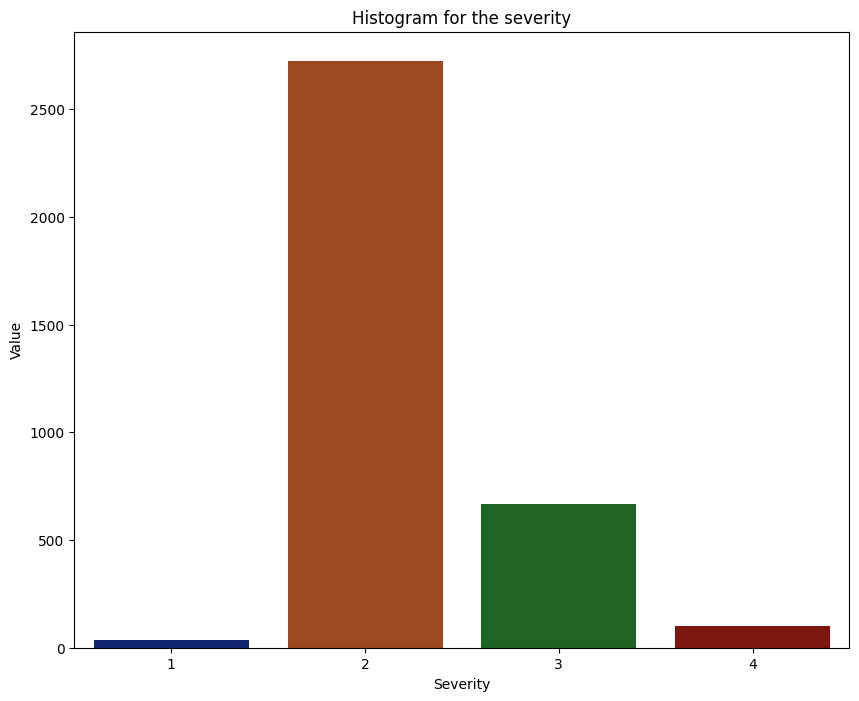

In [ ]:
severity_counts = X["Severity"].value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(x=severity_counts.index, y=severity_counts.values, palette="dark")
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

In [ ]:
size = len(X[X["Severity"]==1].index)
df = pd.DataFrame()
for i in range(1,5):
    S = X[X["Severity"]==i]
    df = pd.concat([df, S.sample(size, random_state=42)], ignore_index=True)
X = df

<ipython-input-225-873c45145721>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




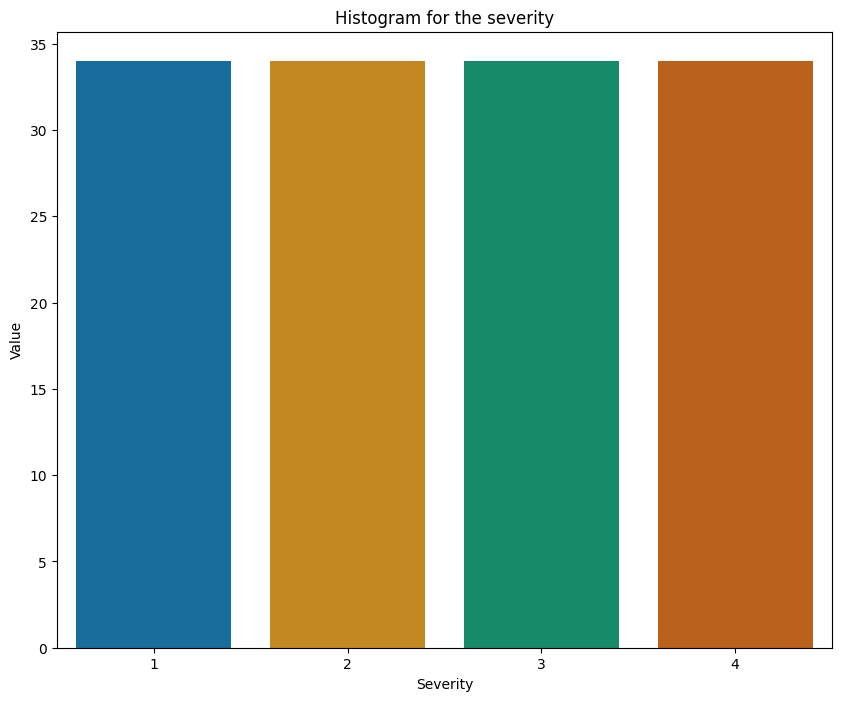

In [ ]:
severity_counts = X["Severity"].value_counts()
plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(x=severity_counts.index, y=severity_counts.values, palette="colorblind")
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

In [ ]:
# Select only numeric features for scaling
numeric_features = ['Temperature(F)', 'Distance(mi)', 'Humidity(%)', 'Pressure(in)',
                    'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)',
                    'Start_Lng', 'Start_Lat', 'Year', 'Month', 'Day']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale the selected numeric features
X[numeric_features] = scaler.fit_transform(X[numeric_features])

# Display the first few rows of the scaled DataFrame
X.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),City,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Civil_Twilight,Year,Month,Weekday,Day
0,1,0.646508,0.348937,0.000000,Brighton,0.449064,0.166667,0.191877,0.662162,NW,...,False,False,False,False,False,Day,0.571429,0.272727,Tuesday,0.433333
1,1,0.993655,0.014886,0.257687,Seattle,0.667360,0.468750,0.928571,0.662162,Variable,...,False,False,False,False,False,Day,0.571429,0.363636,Tuesday,0.833333
2,1,0.750957,0.989122,0.000000,Westborough,0.407484,0.406250,0.745098,0.662162,W,...,False,False,False,False,False,Day,0.571429,0.272727,Tuesday,0.200000
3,1,0.579510,0.006255,0.000000,Santa Rosa,0.854470,0.145833,0.896359,0.662162,NW,...,False,False,False,False,False,Day,0.571429,0.363636,Wednesday,0.166667
4,1,0.411929,0.767306,0.000000,Mountain Rest,0.823285,0.583333,0.743697,0.662162,NE,...,False,False,True,False,False,Day,0.857143,0.727273,Thursday,0.233333


In [ ]:
# Ensure all columns in categorical_features exist in X
missing_columns = [cat for cat in categorical_features if cat not in X.columns]
if missing_columns:
    print("The following columns are missing in X:", missing_columns)
else:
    # Convert columns to categorical dtype
    for cat in categorical_features:
        X[cat] = X[cat].astype("category")

    # Display DataFrame info
    X.info()

The following columns are missing in X: ['Side']


In [ ]:
# Print the names of the features
print("Features in the dataset:")
for feature in df.columns:
    print(feature)

Features in the dataset:
Severity
Start_Lat
Start_Lng
Distance(mi)
City
Temperature(F)
Humidity(%)
Pressure(in)
Visibility(mi)
Wind_Direction
Wind_Speed(mph)
Precipitation(in)
Weather_Condition
Amenity
Bump
Crossing
Give_Way
Junction
No_Exit
Railway
Roundabout
Station
Stop
Traffic_Calming
Traffic_Signal
Civil_Twilight
Year
Month
Weekday
Day


# Model : Artificial Neural Network

In [ ]:
X.shape

(136, 30)

In [ ]:
print(X_encoded.columns)
print(X_sample.columns)
print(y_sample)

Index([], dtype='object')
Index(['Start_Lat', 'Start_Lng', 'Distance(mi)', 'City', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Civil_Twilight', 'Year', 'Month', 'Weekday', 'Day', 'Side'],
      dtype='object')
1060    4
510     2
182     1
942     3
30      1
       ..
1222    4
145     1
445     2
1217    4
1125    4
Name: Severity, Length: 813, dtype: int64


In [ ]:
# Drop the unseen features from X_encoded
"""X_encoded = X_encoded.drop(columns=['Civil_Twilight_Day', 'Civil_Twilight_Night',
       'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday',
       'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday',
       'Weekday_Wednesday',])
"""
#X_encoded = X_encoded.drop(columns=['City', 'Civil_Twilight', 'Weather_Condition', 'Weekday', 'Wind_Direction'])

# Add the missing features to X_encoded
X_encoded['City_Aberdeen'] = 0
X_encoded['City_Abington'] = 0
X_encoded['City_Adamstown'] = 0
X_encoded['City_Adamsville'] = 0
X_encoded['City_Addison'] = 0

In [ ]:
# Step 2: If the shapes are different, subset y to align with X
if X.shape[0] != y.shape[0]:
    y = y.iloc[:len(X)]  # Keep only the first len(X) rows of y

    # Confirm the shapes after alignment
    print("\nAfter aligning the number of samples:")
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)


After aligning the number of samples:
Shape of X: (136, 30)
Shape of y: (136,)


In [ ]:
# Print the first few rows of X
print(X.head())

# Print the number of rows and columns in X
print(X.shape)

# Print the data types of each column in X
print(X.dtypes)

   Severity  Start_Lat  Start_Lng  Distance(mi)  Temperature(F)  Humidity(%)  \
0         1   0.646508   0.348937      0.000000        0.449064     0.166667   
1         1   0.993655   0.014886      0.257687        0.667360     0.468750   
2         1   0.750957   0.989122      0.000000        0.407484     0.406250   
3         1   0.579510   0.006255      0.000000        0.854470     0.145833   
4         1   0.411929   0.767306      0.000000        0.823285     0.583333   

   Pressure(in)  Visibility(mi)  Wind_Speed(mph)  Precipitation(in)  ...  \
0      0.191877        0.662162         0.226415                0.0  ...   
1      0.928571        0.662162         0.113208                0.0  ...   
2      0.745098        0.662162         0.490566                0.0  ...   
3      0.896359        0.662162         0.301887                0.0  ...   
4      0.743697        0.662162         0.490566                0.0  ...   

   Weather_Condition_Windy  Civil_Twilight_Day  Civil_Twilight

In [ ]:
categorical_columns = ['City', 'Wind_Direction', 'Weather_Condition', 'Weekday', 'Day']

encoder = OneHotEncoder(sparse=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_columns]))
X_encoded.columns = encoder.get_feature_names_out(categorical_columns)

# Drop the original categorical columns from X
X = X.drop(columns=categorical_columns)

# Concatenate the encoded columns with the remaining columns in X
X = pd.concat([X, X_encoded], axis=1)

In [ ]:
# Encode categorical variables using one-hot encoding
categorical_columns = X.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(sparse=False)
X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_columns]))
X_encoded.columns = encoder.get_feature_names_out(categorical_columns)

boolean_indexer = ~X.index.isin(X[X['City'].isin(['Aberdeen'])].index)
print(len(boolean_indexer))

# Drop original categorical columns from X
X = X.drop(columns=categorical_columns)

# Concatenate X_encoded with X
X = pd.concat([X, X_encoded], axis=1)

for column in X:
  if X[column].dtype == "object":
    print(column)

X = X[~X.isin(['Aberdeen'])]
y = y[boolean_indexer]

le = LabelEncoder()
X['City'] = le.fit_transform(X['City'])
X['Wind_Direction'] = le.fit_transform(X['Wind_Direction'])
X['Weather_Condition'] = le.fit_transform(X['Weather_Condition'])
X['Weekday'] = le.fit_transform(X['Weekday'])
X['Day'] = le.fit_transform(X['Day'])


In [ ]:
print("Missing values in X:", X.isnull().sum().sum())
print("Missing values in y:", y.isnull().sum())

In [ ]:
"""mlp = MLPClassifier(random_state=42, verbose=False)
parameters = [{"hidden_layer_sizes": [(64, 32), (32, 64, 32)], "max_iter": [200], "solver": ["sgd", "adam"], "activation": ["tanh", "relu"]}]
grid = GridSearchCV(mlp, parameters, verbose=5, n_jobs=-1)
"""
#Starting the timer
start_time = time.perf_counter()

mlp = MLPClassifier(random_state=42, verbose=False)
params = [{"hidden_layer_sizes": [(8, 16)], "max_iter": [450], "solver": ["lbfgs"], "activation":["relu"]}]
grid_search = GridSearchCV(mlp, params, n_jobs=-1, verbose=5, cv=2, return_train_score = True)
grid_search.fit(X, y)

print("Best parameters scores:")
print(grid_search.best_params_)
print("Mean Train Score:", grid_search.cv_results_['mean_train_score'][0])
print("Mean Validation score:", grid_search.best_score_) #Mean cross-validation score of best estimator Expected: 0.7486176281614454
print("Test score: ", grid_search.best_estimator_.score(X_test,y_test)) #Expected: 0.7084822722442277

#Ending the timer
end_time = time.perf_counter()
total_time = end_time-start_time

print("It took {} secs for completing Multilayer Perceptron Training.".format(total_time))